In [4]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import r2_score, mean_squared_error

# import directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
os.path.abspath(os.path.join('eda.ipynb'))

'/Users/bdusch@ibm.com/Documents/Courses/AI Workflow/ai-workflow-capstone/notebooks/eda.ipynb'

The following is a bunch of data wrangling used to engineer features from the data.

In [15]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

def load_ts(datadir, country=None, datatype='all', droptype=False):
    """
    datatypes: all, train, or prod in string format
    """    
    
    ts_datadir = os.path.join(datadir, 'ts-data')
    
    if country:
        c = country.lower()
        onlyfiles = [f for f in os.listdir(ts_datadir) if os.path.isfile(os.path.join(ts_datadir, f))]
        countries_in_dir = [c.split('.')[0] for c in onlyfiles]
        if c not in countries_in_dir:
            raise Excpetion("country not found")
    
    filename = os.path.join(ts_datadir, f'{c}.csv')
    df_ts = pd.read_csv(filename)
    if datatype.lower() == 'train':
        df_ts = df_ts[df_ts['type'] == 'train']        
    elif datatype.lower() == 'prod':
        df_ts = df_ts[df_ts['type'] == 'prod']
    elif datatype.lower() == 'all':
        # all data
        pass
    else:
        # all data
        raise Exception("datatype must be train, prod, or all")
    
    # remove type column
    if droptype:
        df_ts = df_ts.drop(columns=['type'])
    return df_ts

def engineer_features(df, datatype='all', log=True):
    """
    df: country based time series
    datatypes: all, train, or prod in string format
    """
    def refactor_original(df, remove_early=True):
        
        columns_p1 = ["date", "purchases", "unique_invoices", "unique_streams", "total_views", "year_month"]
        columns_p2 = ["type", "revenue"]
        df = pd.concat([df[columns_p1], pd.get_dummies(df.month, prefix='month'),
                            pd.get_dummies(df.year, prefix='year'), df[columns_p2]], axis=1)

        # add months as new variables if not in variables
        for i in range(1, 13):
            month = f'month_{i:02d}'
            if month not in df.columns:
                df[month] = 0
                df[month] = df[month].astype(int)

        # add years as new variables if not in variables
        for i in range(2017, 2020):
            year = f'year_{i}'
            if year not in df.columns:
                df[year] = 0
                df[year] = df[year].astype(int)


        df = df[['date', 'purchases', 'unique_invoices', 'unique_streams', 'total_views',
                 'month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06',
                 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12',
                 'year_2017', 'year_2018', 'year_2019',
                 'type', 'revenue']]
        return df
    
    if datatype.lower() not in ['train', 'prod', 'all']:
        raise Exception("datatype must be train, prod, or all")
    
    
    # refactor
    df = refactor_original(df)
    
    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')
    
    ## engineer some features
    eng_features = defaultdict(list)
    
    # [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    # [7, 14, 28, 70]
    previous = [7, 14, 28, 70]
    y = np.zeros(dates.size)
    # first is date, last is revenue
    variables = ['purchases', 'unique_invoices', 'unique_streams', 'total_views', 'revenue']
    months = [f'month_{i:02d}' for i in range(1, 13)]
    years = [f'year_{i}' for i in range(2017, 2020)]
    
    for d,day in enumerate(dates):
        # current day
        current = np.datetime64(day, 'D')
        
        ## get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        # time-based features
        for variable in variables:
            ## use windows in time back from a specific date
            for num in previous:
                prev = current - np.timedelta64(num, 'D')
                mask = np.in1d(dates, np.arange(prev, current, dtype='datetime64[D]'))
                sum_var = df[mask][variable].sum()
                eng_features[f"previous_{num}_{variable}"].append(sum_var)
                                
            ## attempt to capture monthly trend with previous years data (if present)
            start_date = current - np.timedelta64(365,'D')
            stop_date = plus_30 - np.timedelta64(365,'D')
            mask = np.in1d(dates, np.arange(start_date, stop_date,dtype='datetime64[D]'))
            eng_features[f'previous_year_{variable}'].append(df[mask][variable].sum())

        # get type
        mask = np.in1d(dates, np.arange(current,current+1,dtype='datetime64[D]'))
        var = df.loc[mask, "type"].values[0]
        eng_features["type"].append(var)

    X = pd.DataFrame(eng_features)

    # prune data depending on type
    if datatype.lower() == 'train':
        dates = dates[X['type'] == 'train']
        y = y[X['type'] == 'train']
        X = X[X['type'] == 'train']
    elif datatype.lower() == 'prod':
        dates = dates[X['type'] == 'prod']
        y = y[X['type'] == 'prod']
        X = X[X['type'] == 'prod']
    elif datatype.lower() == 'all':
        # all data
        pass
    else:
        # all data
        raise Exception("datatype must be train, prod, or all")
        
    # drop type
    X = X.drop(columns=['type'])

    ## combine features in to df and remove rows with all zeros
    X.fillna(0, inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    ## remove the last 30 days (because the target is not reliable)
    mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)
    
    if log:
        y = np.log(y)
    
    return X, y, dates

Next step is loading the data.

In [7]:
datadir = os.path.join(module_path, "app", "data")

train_datadir = os.path.join(datadir, "cs-train")
prod_datadir = os.path.join(datadir, "cs-production")

We'll load all the data for trainign and production and get the top 15 countries with regards to revenue.

In [8]:
df_train = fetch_data(train_datadir)
df_prod = fetch_data(prod_datadir)

df_train['type'] = 'train'
df_prod['type'] = 'prod'
df = pd.concat([df_train, df_prod])

## find the top N countries (wrt revenue)
N = 15
table = pd.pivot_table(df,index='country', values="price", aggfunc='sum')
table.columns = ['total_revenue']
table.sort_values(by='total_revenue',inplace=True,ascending=False)
top_countries =  np.array(list(table.index))[:N].tolist()

table = table['total_revenue']

Next is a visualization of the total revenue per country.

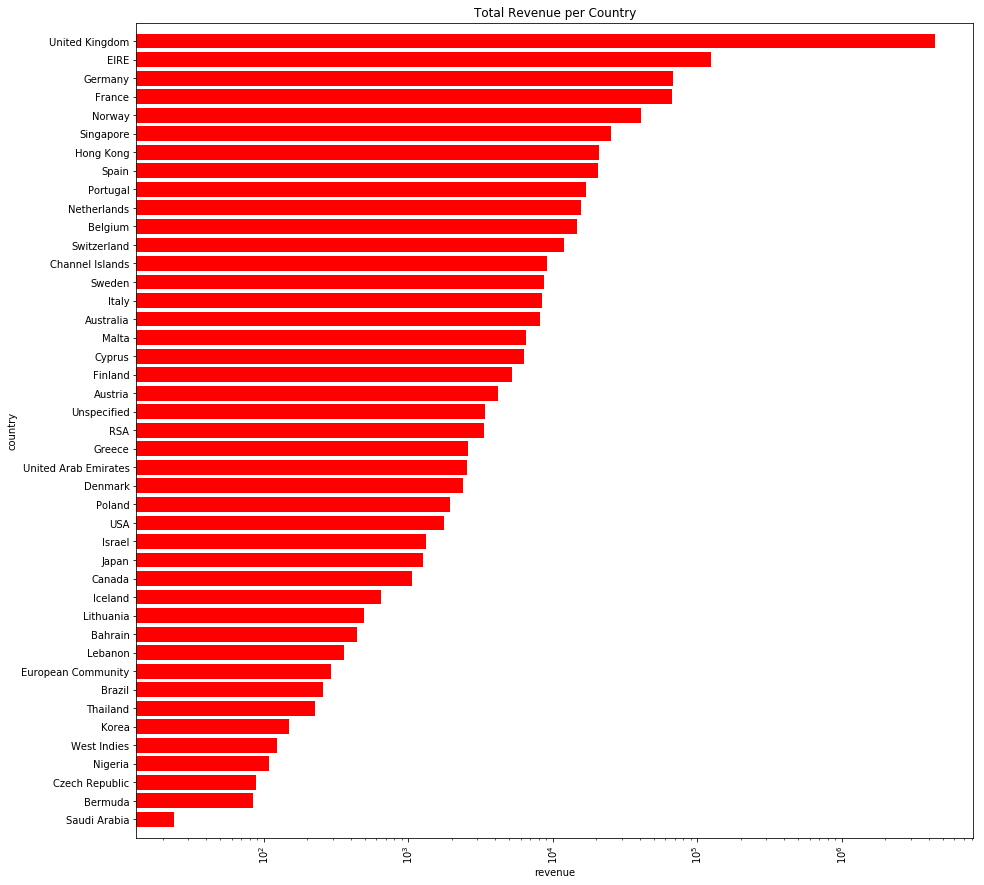

In [5]:
plt.figure(figsize=(15,15))
plt.barh(table.index[::-1], table.values[::-1],
        color="r", align="center", log=True)
plt.xticks(rotation=90)
plt.ylim([-1, len(table)])
plt.xlabel('revenue')
plt.ylabel('country')
plt.title('Total Revenue per Country')
plt.show()

Now we'll engineer features and look at the number of samples and features per country - models will be on this basis.

In [17]:
# parameters
log = False

data = {}
for country in top_countries:
    d = {}
    dfi = load_ts(datadir, country=country, datatype='all', droptype=False)

    dfi_train = dfi[dfi['type'] == 'train']
    dfi_prod = dfi[dfi['type'] == 'prod']
    
    # training data
    X_train, y_train, dates_train = engineer_features(dfi, datatype='train', log=log)
    print(f"{country} Training Data: {dfi_train.shape}, {X_train.shape}")

    # get revenue
    if log:
        r_train = np.exp(y_train)
    else:
        r_train = y_train
        
    # production data
    
    X_prod, y_prod, dates_prod = engineer_features(dfi, datatype='prod', log=log)
    print(f"{country} Production Data: {dfi_prod.shape}, {X_prod.shape}")

    if log:
        r_prod = np.exp(y_prod)
    else:
        r_prod = y_prod
        
    # save data
    d['data'] = dfi
    
    d['train'] = {}
    d['train']['data'] = dfi_train
    d['train']['features'] = X_train
    d['train']['target'] = y_train
    d['train']['dates'] = dates_train
    d['train']['revenue'] = r_train
    
    d['prod'] = {}
    d['prod']['data'] = dfi_prod
    d['prod']['features'] = X_prod
    d['prod']['target'] = y_prod
    d['prod']['dates'] = dates_prod
    d['prod']['revenue'] = r_prod
    
    data[country] = d

United Kingdom Training Data: (638, 10), (580, 25)
United Kingdom Production Data: (122, 10), (92, 25)
EIRE Training Data: (638, 10), (580, 25)
EIRE Production Data: (122, 10), (92, 25)
Germany Training Data: (638, 10), (580, 25)
Germany Production Data: (122, 10), (92, 25)
France Training Data: (638, 10), (580, 25)
France Production Data: (122, 10), (92, 25)
Norway Training Data: (608, 10), (438, 25)
Norway Production Data: (122, 10), (92, 25)
Singapore Training Data: (487, 10), (266, 25)
Singapore Production Data: (61, 10), (24, 25)
Hong Kong Training Data: (487, 10), (343, 25)
Hong Kong Production Data: (92, 10), (62, 25)
Spain Training Data: (638, 10), (578, 25)
Spain Production Data: (122, 10), (92, 25)
Portugal Training Data: (638, 10), (580, 25)
Portugal Production Data: (122, 10), (92, 25)
Netherlands Training Data: (638, 10), (579, 25)
Netherlands Production Data: (122, 10), (92, 25)
Belgium Training Data: (638, 10), (580, 25)
Belgium Production Data: (122, 10), (92, 25)
Switz

Look at the 30 day rolling some of revenue per country for the top countries.

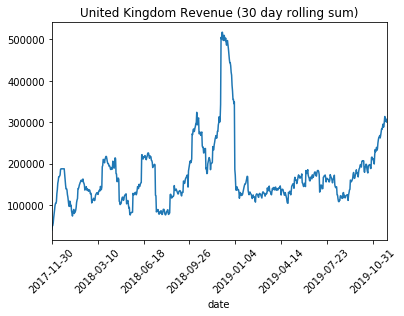

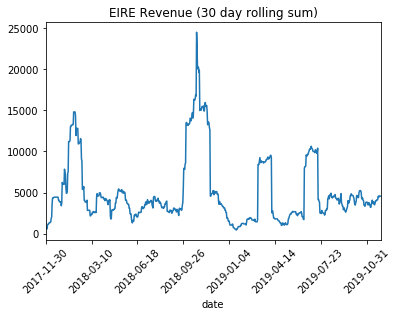

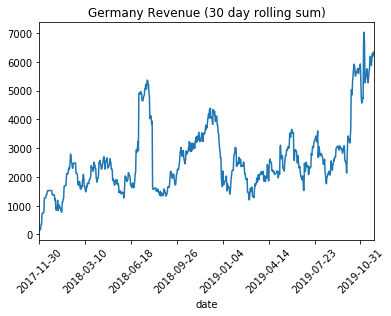

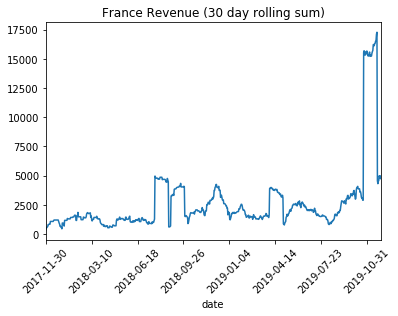

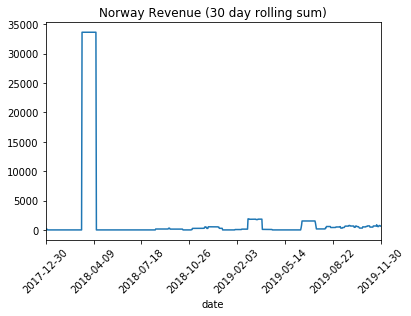

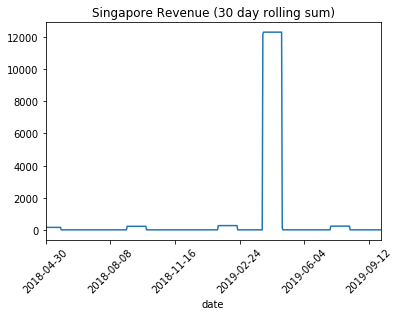

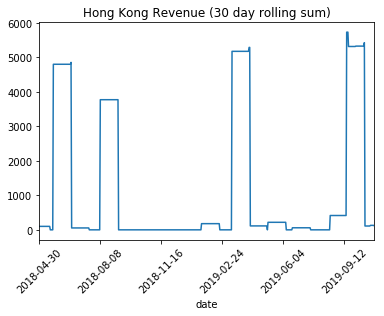

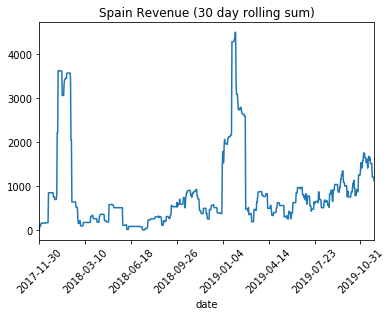

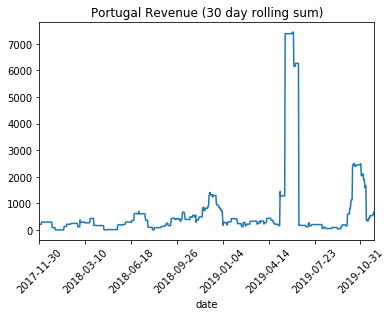

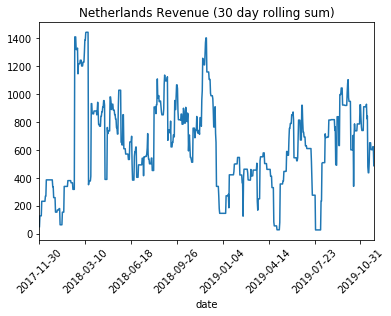

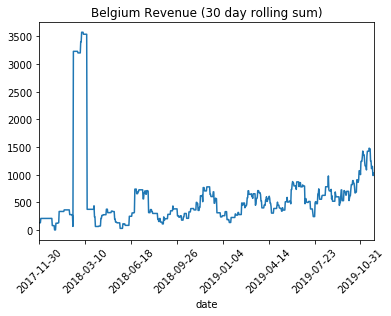

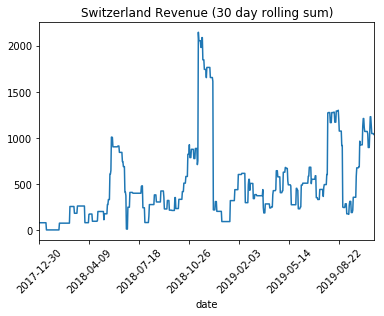

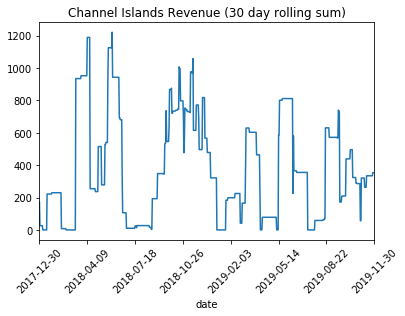

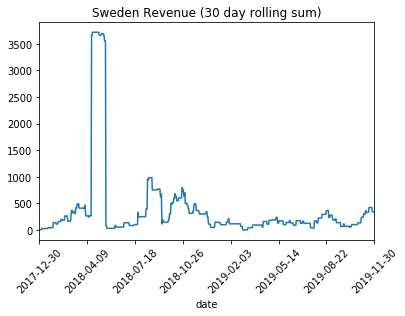

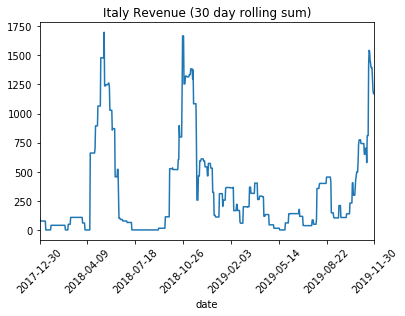

In [26]:
for country in top_countries:
    revenue_30day = data[country]['data']['revenue'].rolling(30).sum().iloc[29:]
    revenue_30day.index = data[country]['data']['date'].iloc[29:]
    revenue_30day.plot()
    plt.xticks(rotation = 45)
    plt.title(f"{country} Revenue (30 day rolling sum)")
    plt.show()
    

Look at the distribution of the log(revenue) which, if revenue is log-normally distributed (central limit theorem based on sums of variables), then the log of revenue should be normally distributed. This seems to hold for the large revenue countries (e.g. United Kingdom)

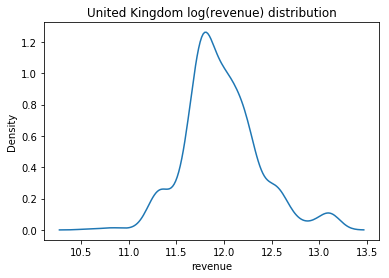

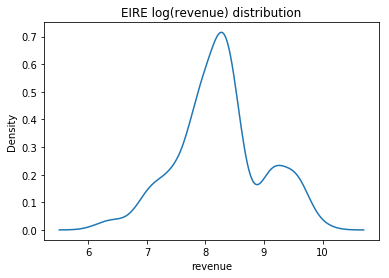

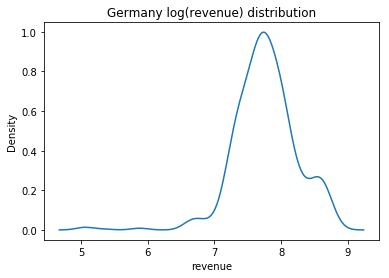

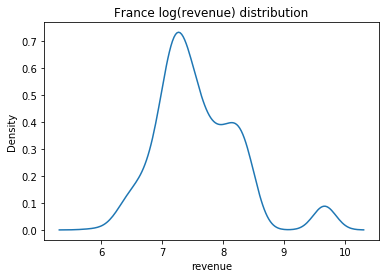

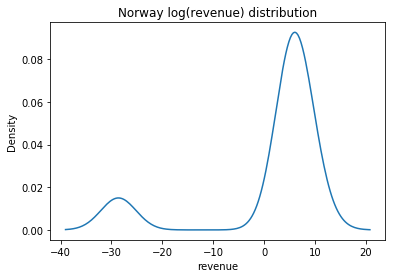

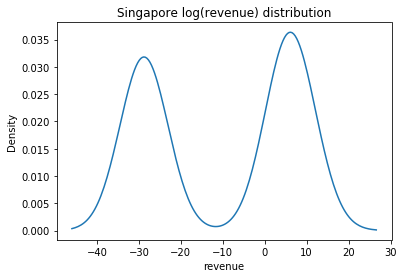

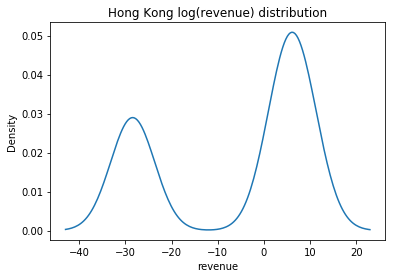

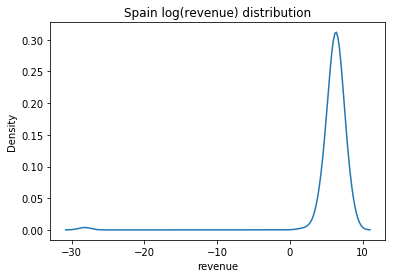

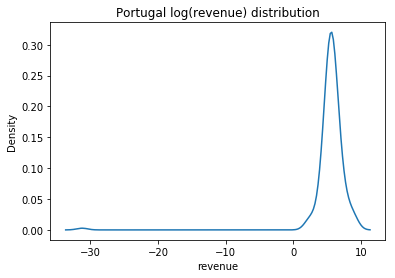

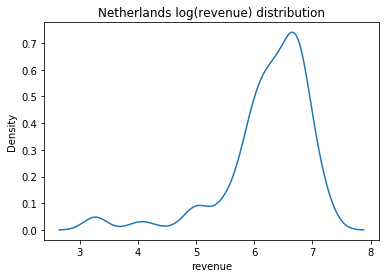

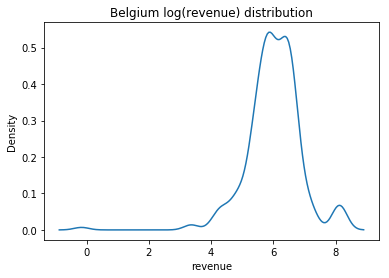

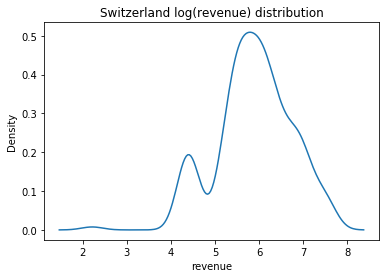

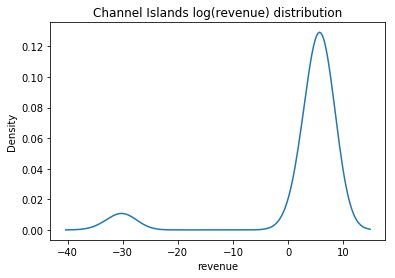

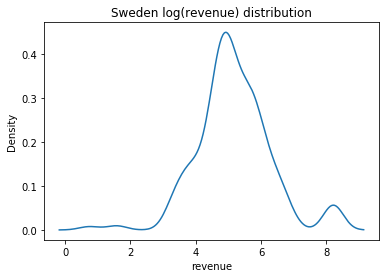

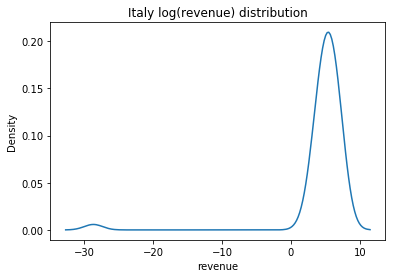

In [75]:
for country in top_countries:
    forecasted_revenue = data[country]['data']['revenue'].rolling(30).sum().shift(-29)
    sns.kdeplot(np.log(forecasted_revenue[forecasted_revenue > 0]))
    plt.title(f"{country} log(revenue) distribution")
    plt.show()

Now we'll look at the correlations for the at-moment-of-time variables - unique invoices, unique streams, total views, revenue, and forecasted revenue.

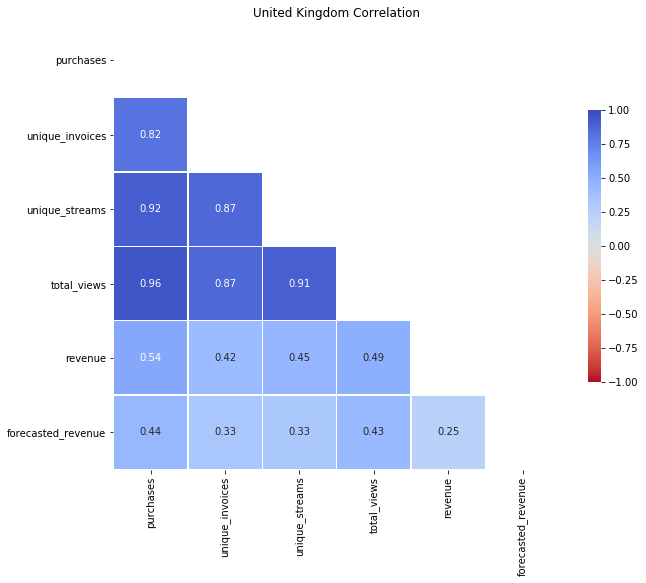

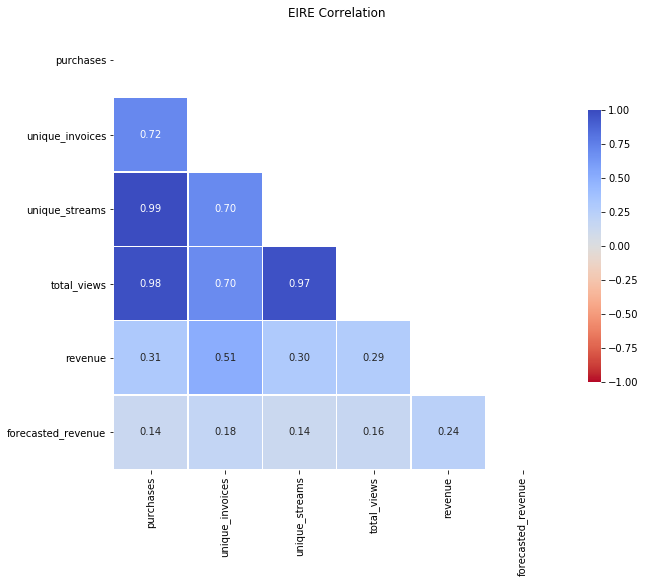

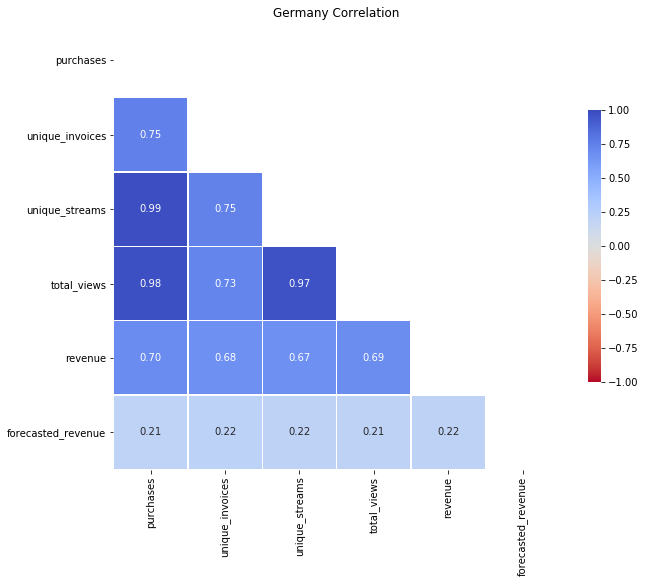

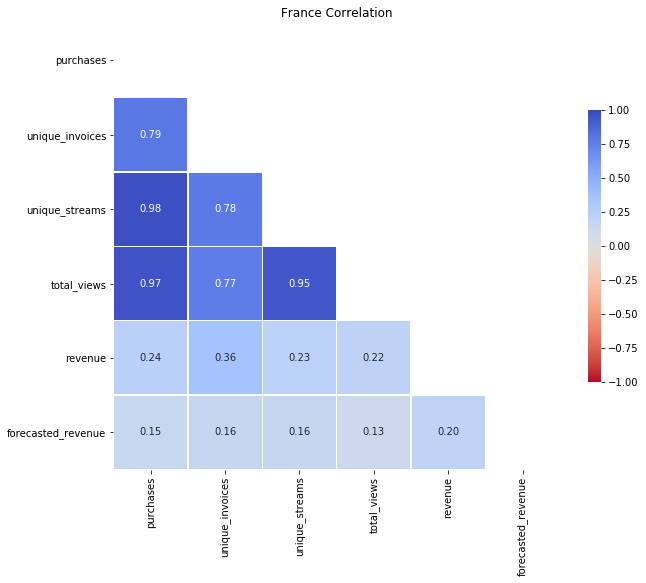

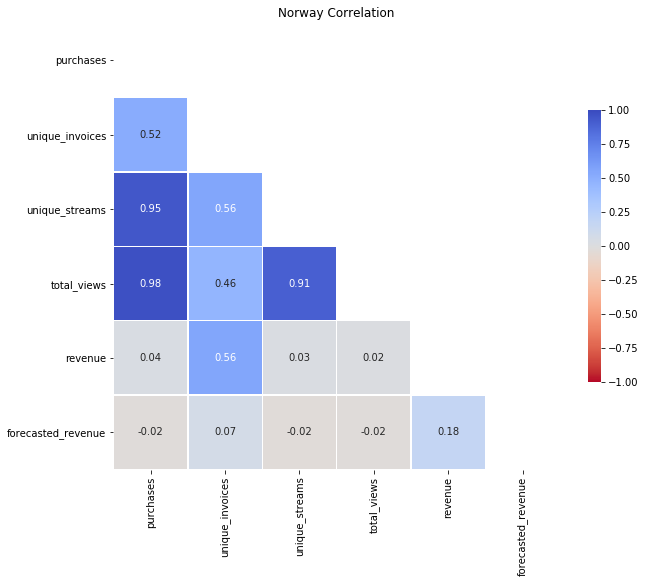

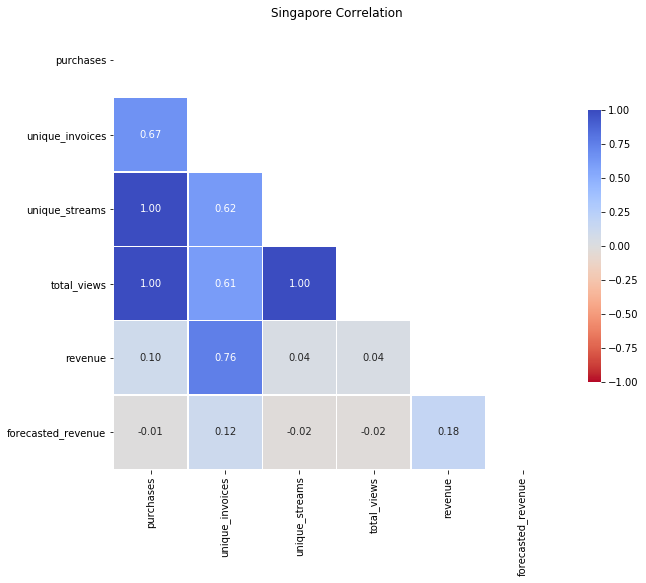

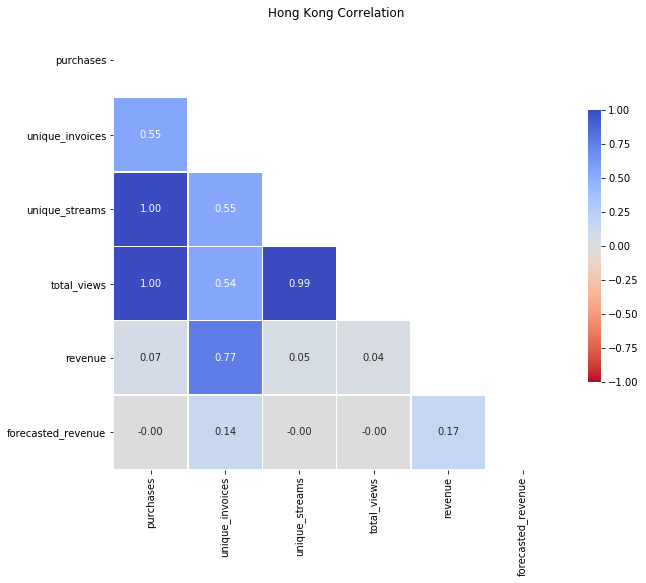

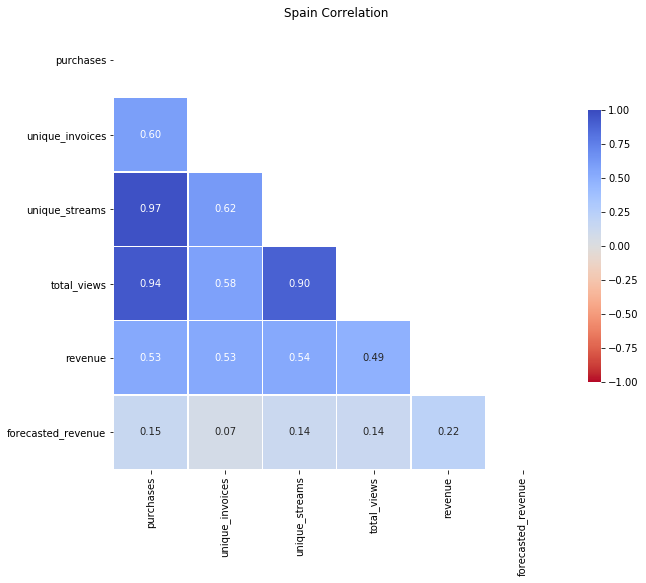

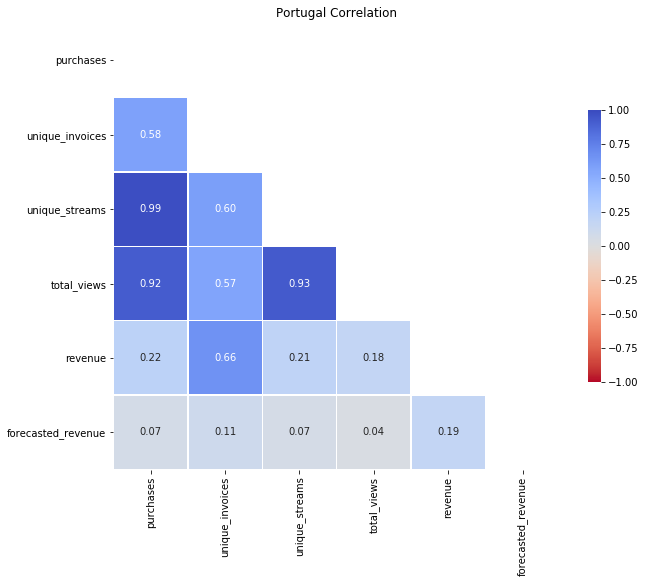

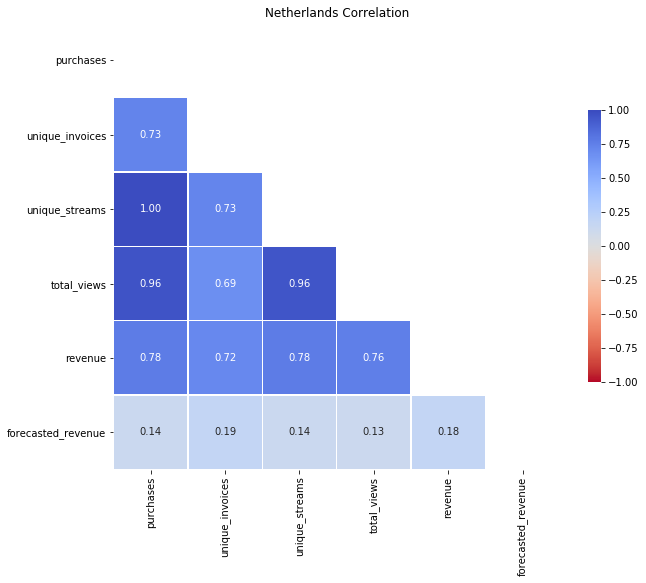

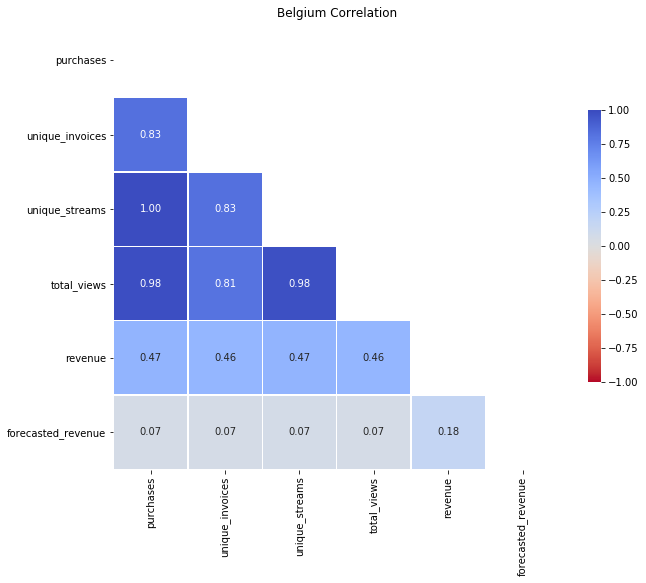

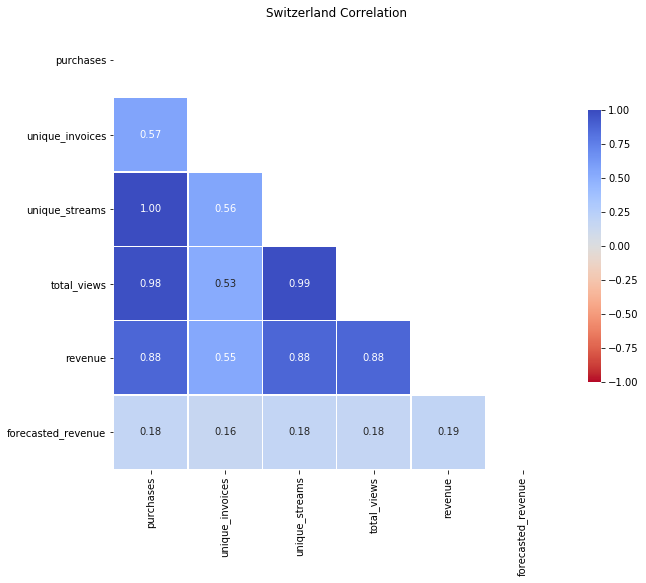

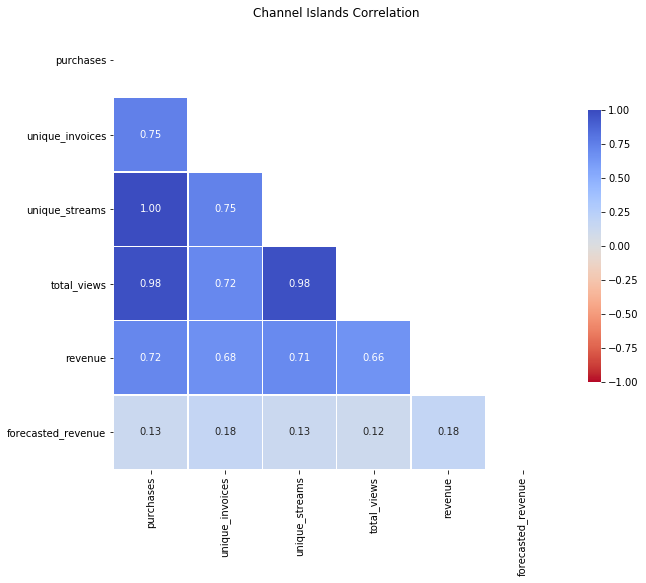

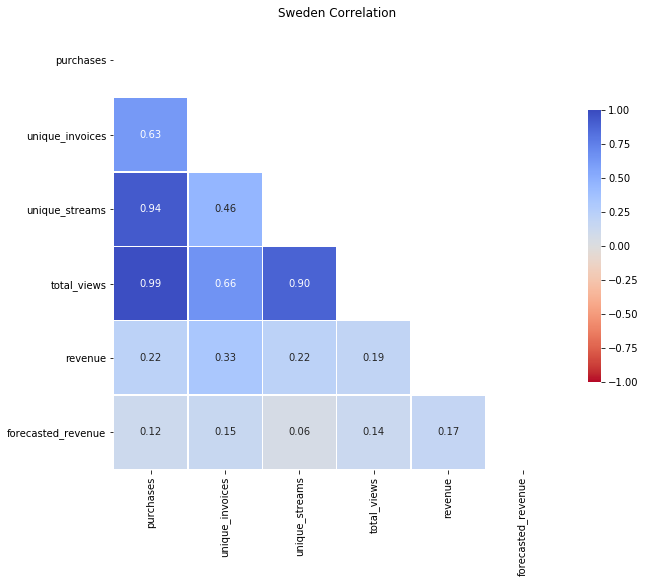

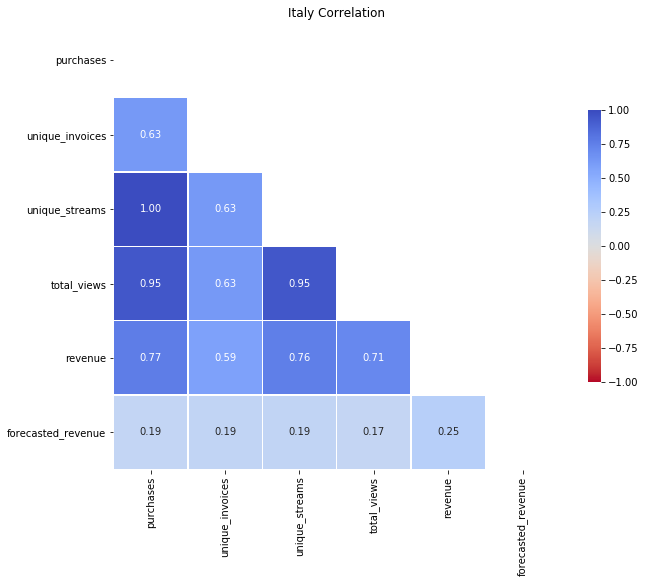

In [73]:
def plot_correlation(corr, vmin=None, vmax=.3, fmt='.2f', figsize=(15, 10), title='', drop_mask=False):
    # Generate a mask for the upper triangle
    if not drop_mask:
        mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    if not drop_mask:
        g = sns.heatmap(corr, mask=mask, vmin=vmin, vmax=vmax, center=0, cmap= 'coolwarm_r',
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt=fmt)
    else:
        g = sns.heatmap(corr, vmin=vmin, vmax=vmax, center=0, cmap= 'coolwarm_r',
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt=fmt)
    plt.title(title)
    plt.show()
    return g

for country in top_countries:
    df_country = pd.concat([data[country]['data'].drop(['month', 'year'], axis=1),
                            pd.DataFrame(data[country]['data']['revenue'].rolling(30).sum().shift(-29).values,
                                         columns=['forecasted_revenue'])
              ], axis=1)

    corr_feature_plot = df_country.corr()
    
    plot_correlation(corr_feature_plot, vmax=1, vmin=-1,
                 title=f"{country} Correlation", figsize=(10, 10), drop_mask=False)

In [65]:
corr_feature_plot

,purchases,unique_invoices,unique_streams,total_views,revenue,forecasted_revenue
purchases,1.000000,0.819562,0.919447,0.958284,0.541156,0.442191
unique_invoices,0.819562,1.000000,0.872933,0.873294,0.423763,0.329328
unique_streams,0.919447,0.872933,1.000000,0.913206,0.449600,0.327915
total_views,0.958284,0.873294,0.913206,1.000000,0.494640,0.431878
revenue,0.541156,0.423763,0.449600,0.494640,1.000000,0.247368
forecasted_revenue,0.442191,0.329328,0.327915,0.431878,0.247368,1.000000


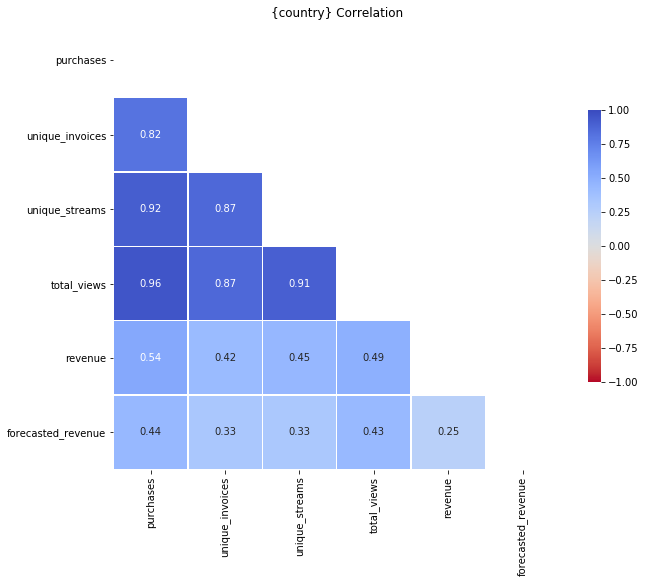

In [69]:
plot_correlation(corr_feature_plot, vmax=1, vmin=-1,
                 title="{country} Correlation", figsize=(10, 10), drop_mask=False)

In [56]:
data[country]['data']['revenue'].rolling(30).sum().shift(-29)

0       39445.59
1       48608.66
2       49871.94
3       56101.05
4       68290.84
5       77183.11
6       88070.10
7       98721.48
8      103585.55
9      103585.55
10     108153.75
11     127251.42
12     136770.09
13     152380.26
14     158384.00
15     167944.02
16     167944.02
17     169755.53
18     172406.24
19     185660.78
20     187241.07
21     187241.07
22     187241.07
23     187241.07
24     187241.07
25     187241.07
26     187241.07
27     187241.07
28     173959.95
29     160736.98
         ...    
730    300347.31
731          NaN
732          NaN
733          NaN
734          NaN
735          NaN
736          NaN
737          NaN
738          NaN
739          NaN
740          NaN
741          NaN
742          NaN
743          NaN
744          NaN
745          NaN
746          NaN
747          NaN
748          NaN
749          NaN
750          NaN
751          NaN
752          NaN
753          NaN
754          NaN
755          NaN
756          NaN
757          N